## Importing Libraries and Modules

In [0]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D,Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras.models import Sequential
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras import backend as K
from keras import regularizers
from keras import optimizers
% matplotlib inline
import numpy as np
np.random.seed(2017)
import time
import math
import matplotlib.gridspec as gridspec
from keras.preprocessing import image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.gridspec as gridspec

## Importing Data Set

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [19]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


###Classes of Data Set

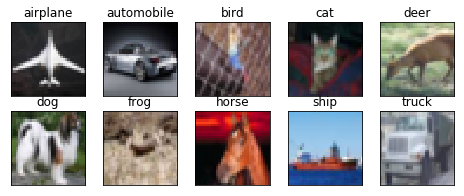

In [20]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Function for Model History plot

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Function for Accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [24]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## CutOut Function

In [0]:
# Function for CutOut
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

##LR Finder Function

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [27]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.01989002 1.0052702
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

## Define Model

In [30]:
# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.0001),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (1, 1)))


model.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.0001),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3),kernel_regularizer=regularizers.l2(0.0001),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(32, (1, 1)))


model.add(Conv2D(128, (3, 3),kernel_regularizer=regularizers.l2(0.0001), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3),kernel_regularizer=regularizers.l2(0.0001), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(10, (1, 1),name='last_layer'))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### Total params: 455,370

## Starting Learning Rate


In [0]:
#model1 = func_model()
#model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#model1.summary()
#lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(X_train.shape[0]/512))
#model1.fit(X_train, Y_train, callbacks=[lr_finder] )
#lr_finder.plot()

## Training Model

In [32]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1))                                                                   



# Train the model
model_info = model.fit_generator(datagen.flow(X_train, Y_train, batch_size =128),
                                 steps_per_epoch=390, epochs = 100, 
                                 validation_data = (test_features, test_labels),verbose =1) 
                                 

# compute test accuracy
#print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Epoch 1/100
390/390 [==============================] - 13s 34ms/step - loss: 1.7632 - acc: 0.3697 - val_loss: 3.0635 - val_acc: 0.1518
Epoch 2/100
390/390 [==============================] - 12s 30ms/step - loss: 1.4917 - acc: 0.4750 - val_loss: 2.9294 - val_acc: 0.1921
Epoch 3/100
390/390 [==============================] - 12s 31ms/step - loss: 1.3604 - acc: 0.5255 - val_loss: 2.5563 - val_acc: 0.2160
Epoch 4/100
390/390 [==============================] - 12s 31ms/step - loss: 1.2729 - acc: 0.5571 - val_loss: 2.8746 - val_acc: 0.1787
Epoch 5/100
390/390 [==============================] - 12s 31ms/step - loss: 1.1986 - acc: 0.5837 - val_loss: 2.7608 - val_acc: 0.2646
Epoch 6/100
390/390 [==============================] - 12s 31ms/step - loss: 1.1539 - acc: 0.6021 - val_loss: 2.5513 - val_acc: 0.2495
Epoch 7/100
390/390 [==============================] - 12s 31ms/step - loss: 1.1048 - acc: 0.6192 - val_loss: 2.8497 - val_acc: 0.2389
Epoch 8/100
390/390 [==============================] - 

## Misclassified Images

In [0]:
def get_cifar10_labels():
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

def gradcam(model, layer, img, class_idx, preprocess_func=None, preprocess_img=min_max_scale,
            show=False):
    x = np.expand_dims(image.img_to_array(img), axis=0)
    img = np.copy(img)
    class_idx = np.argmax(class_idx, axis=0) if type(class_idx) == list or type(class_idx) == np.ndarray else class_idx
    if preprocess_func is not None:
        x = preprocess_func(x)
    if preprocess_img is not None:
        img = preprocess_img(img)
    preds = model.predict(x)
    preds = np.argmax(preds, axis=1)[0]

    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer)
    layer_out_channels = last_conv_layer.output_shape[-1]

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(layer_out_channels):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    heatmap = heatmap / 255
    for i in range(len(heatmap)):
        for j in range(len(heatmap[0])):
            if heatmap[i][j][1] <= 0.01 and heatmap[i][j][2] <= 0.01:
                heatmap[i][j] = 0

    superimposed_img = 0.6 * img + 0.4 * heatmap
    for i in range(len(heatmap)):
        for j in range(len(heatmap[0])):
            if np.sum(heatmap[i][j]) == 0:
                superimposed_img[i][j] = img[i][j]

    superimposed_img = np.clip(superimposed_img, 0, 1, )
    if show:
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        plt.imshow(heatmap)
        plt.axis("off")
        plt.show()
        plt.imshow(superimposed_img)
        plt.axis("off")
        plt.show()
    return img, heatmap, superimposed_img, preds


def show_examples_with_gradcam(model, layer, images, labels, classes=None, preprocess_func=None, preprocess_img=None,
                               image_size_multiplier=3,
                               show_actual=True, show_heatmap=False, show_superimposed=True):
    columns = 5
    rows = int(np.ceil(len(images) / columns))
    num_inner_rows = int(show_actual + show_heatmap + show_superimposed)
    labels = np.argmax(labels, axis=1) if type(labels[0]) == list or type(labels[0]) == np.ndarray else labels
    fig_height = rows * image_size_multiplier * num_inner_rows
    fig_width = columns * image_size_multiplier
    fig = plt.figure(figsize=(fig_width, fig_height))
    outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
    for i in range(rows * columns):
        if i >= len(images):
            break
        x = images[i]
        y = labels[i]
        img, heatmap, superimposed_img, prediction = gradcam(model, layer, x, y, preprocess_func=preprocess_func,
                                                             preprocess_img=preprocess_img, show=False)
        inner = gridspec.GridSpecFromSubplotSpec(num_inner_rows, 1,
                                                 subplot_spec=outer[i], wspace=0.0, hspace=0.05)

        imgs = []
        if show_actual:
            imgs.append(img)
        if show_heatmap:
            imgs.append(heatmap)
        if show_superimposed:
            imgs.append(superimposed_img)
        label = classes[y] if classes is not None else ""
        label = label.split(' ', 1)[0]
        prediction = classes[prediction]
        titles = [("Actual:" + label + " Pred:" + prediction).replace(' ', '\n')]
        for j in range(num_inner_rows):
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(imgs[j])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(titles.pop() if len(titles) > 0 else "")
            fig.add_subplot(ax)

    fig.show()
    
def find_misclassified(X, y_true, y_pred):
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    misclassified = y_true != y_pred
    X = X[misclassified]
    y_true = y_true[misclassified]
    y_pred = y_pred[misclassified]
    return X, y_true, y_pred

def show_misclassified_with_gradcam(model, layer, iterator, classes=None, preprocess_func=None, preprocess_img=None,
                                    image_size_multiplier=3, examples=25,
                                    show_actual=True, show_heatmap=False, show_superimposed=True):
    columns = 5
    rows = int(np.ceil(examples / columns))
    images = []
    labels = []
    predictions = []
    while len(images) < examples:
        batchX, batchY = iterator.next()
        preds = model.predict(batchX)
        X, y_true, y_pred = find_misclassified(batchX, batchY, preds)
        images.extend(X)
        labels.extend(y_true)
        predictions.extend(y_pred)

    images = images[:examples]
    labels = labels[:examples]
    predictions = predictions[:examples]

    show_examples_with_gradcam(model, layer, images, labels, classes=classes, preprocess_func=preprocess_func,
                               preprocess_img=preprocess_img, image_size_multiplier=image_size_multiplier)


In [0]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             preprocessing_function=None)
_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=100,shuffle=False)
X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)

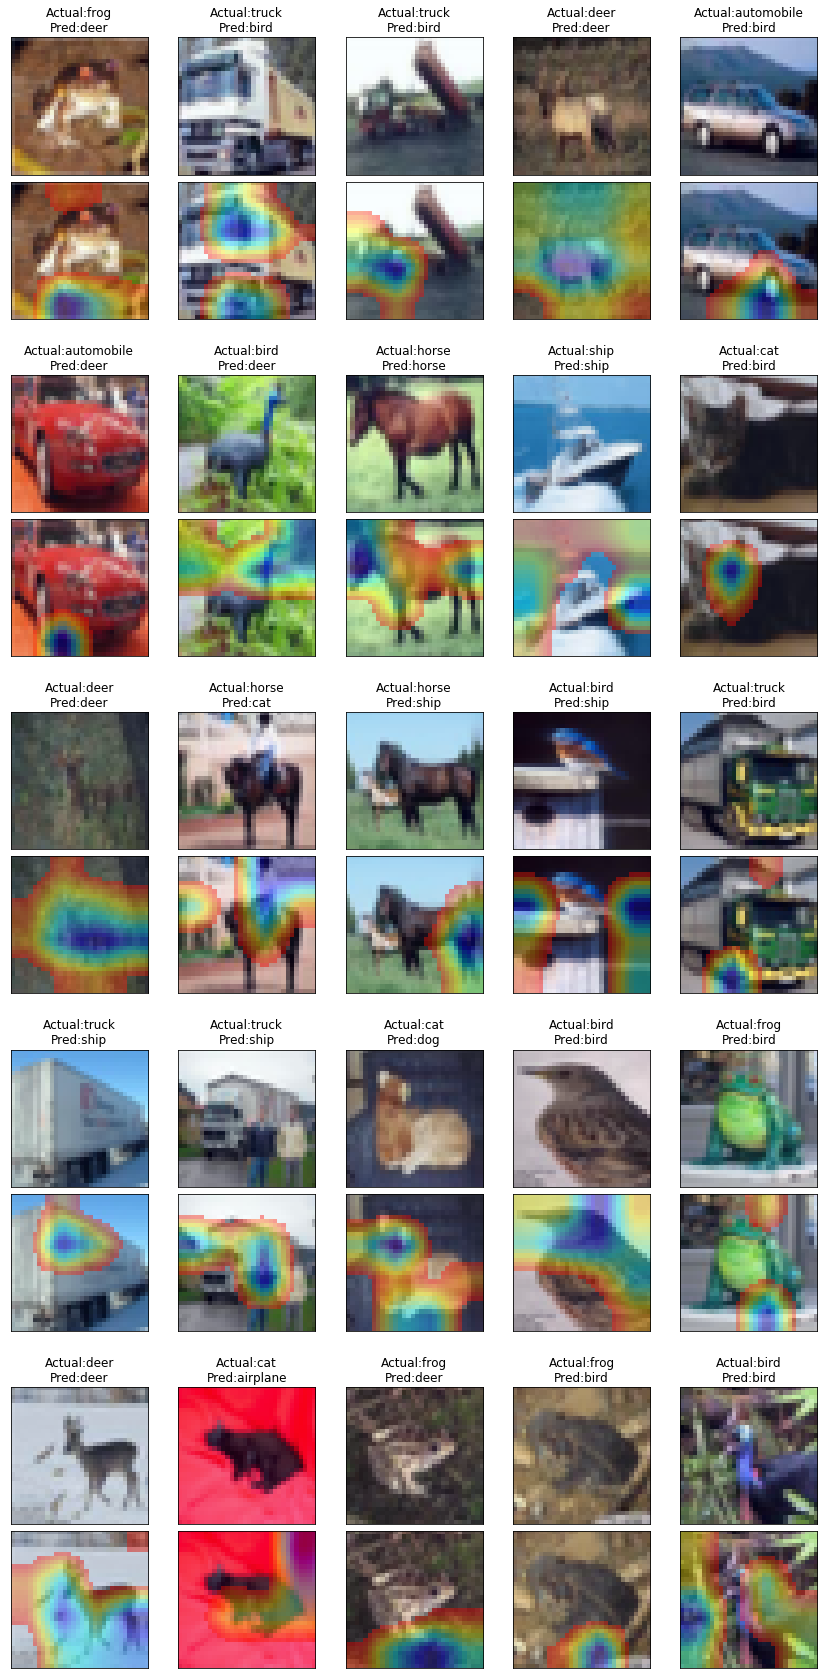

In [35]:
#np.seterr(divide='ignore', invalid='ignore')
show_examples_with_gradcam(model,layer="last_layer",images=X_e[0:25], labels=Y_e[0:25],
                           classes=get_cifar10_labels())